## Language Modelling Task (45 points)

In this task, you will train a language model and use the trained model to generate text. You are expected to use Google Colab for this task. 3 options from the Project Gutenberg is provided as data:  Pride and Prejudice, A Tale of Two Cities and The Brothers Karamazov. You  will  use  cross-entropy  loss  for  optimization  and  use  perplexity  as  a  metric. You should get a maximum validation perplexity of 120 for Pride and Prejudice and 125 for the other books.  Experimenting with only one book is sufficient.  This is not a sufficient value for good language modelling but it is sufficient for this assignment.  For a detailed explanation of cross-entropy and perplexity of a language model, check: https://towardsdatascience.com/the-relationship-between-perplexity-and-entropy-in-nlp-f81888775ccc and https://towardsdatascience.com/perplexity-in-language-models-87a196019a94

You need to implement the dataset object and and create dataloaders from it. Then you need to implement network models, training loops and evaluation and generation functions. Instructions for experimentation is provided in Training and Experimentation section.

In [56]:
# This part probably will be enough for utilizing Drive in Colab
# but examine links above if you encounter with problems.
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


### Fill in required parts of code 

In [57]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import re
import time
from collections import Counter
from torch.utils.data import DataLoader
from datetime import datetime
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Fill \_read_data( ), \__len__( ), \__getitem__( ) functions. 

In \_read_data( ): Read the data word by word and split data into training and validation sets. 
            You can choose to either include punctuation marks or exclude the
            punctuation marks and add a \<eos> (end of sentence) token to 
            state the end of a sentence. Make sure words are cleaned and do not contain 
            characters like '\r' etc. Words that start with a capital letter would also
            unnecessarily increase the lexicon size. Based on your preference, 
            you can also remove the parts of the book that belong to Project Gutenberg.
                     
Required steps to form the lexicon is already given.


In \__len__( ): return size of dataset

In \__getitem__( ): return sample with index idx, should return data and target
                    Uses sliding window

In [59]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        seq_length,
        path,
        train=True,
        train_split=0.8,
        device='cuda'
    ):
        """ Dataset constructor
        Args:
        seq_length: sequence length (window size)
        path: path of the data file
        train: train vs validation option
        train_split: ratio of the training data
        device: cpu or cuda
        """
        self.seq_length = seq_length
        #self.mode = mode
        self.train_split = train_split
        self.path = path
        self.all_data, self.train_data, self.eval_data = self._read_data()
        
        self.unique_data = self._find_unique()

        self.idx_data = {idx: data for idx, data in enumerate(self.unique_data)}
        self.data_idx = {data: idx for idx, data in enumerate(self.unique_data)}
        
        self.data = self.train_data if train else self.eval_data

        self.indexed_data = np.array([self.data_idx[i] for i in self.data])
        
        self.indexed_data = torch.from_numpy(self.indexed_data).to(device)

    def _read_data(self):
        """ Reads data word by word and splits data into training and validation
            You can choose to either include punctuation marks or exclude the
            punctuation marks and add a <eos> (end of sentence) token to 
            state the end of a sentence. Make sure words are cleaned and do not contain 
            characters like '\r' etc. Words that start with a capital letter would also
            unnecessarily increase the lexicon size. Based on your preference, 
            you can also remove the parts of the book that belong to Project Gutenberg.
            Fill in parts with None 
        """
        text = open(self.path, 'rb').read().decode(encoding='utf-8')
        #text = text.replace(".", " <eos>")
        #text = text.replace("\n", " ")
                                                                     # Project Gutenberg part is removed.
        text = text.lower()                                          # Capital letters are changed to lower case
        text = re.sub(r"([.!,?'\"])", r" \1 ", text)                 # i did not choose to exclude the punctuation marks, and used them as a word, so added space to begining and end
                                                                     # So split function can split them
        text = re.sub(r"[^a-zA-Z0-9.,?!'\"]", " ", text)             # Only alphabet letters, numbers and punctuation marks are taken  
        data = text.split()                                          # split data to a list
        # print(data)
        train_data = data[:int(len(data)*self.train_split)]          # %80 percent taken as a training
        eval_data = data[int(len(data)*self.train_split):]           # %20 percent for testing
        return data, train_data, eval_data

    def _find_unique(self):
        """ Finds unique words and sorts them according to their frequency - most frequent first
        """
        data_count = Counter(self.all_data)
        
        return sorted(data_count, key=data_count.get, reverse=True)

    def __len__(self):
        """ Size of dataset
            Fill in parts with None 
        """
        return len(self.indexed_data) - self.seq_length               # size of data set - seqlength  int(len(self.data)/self.seq_length)

    def __getitem__(self, idx):
        """ Get sample with index idx, should return data and target
            Uses sliding window
            Fill in parts with None 
        # """
        
        x = self.indexed_data[idx : idx + self.seq_length]            # input starting from idx to length of sequence
        y = self.indexed_data[idx + 1 : idx + self.seq_length + 1]    # output of idx is idx + 1. So y is starting from idx + 1 to length of sequence +1

        return (x, y)

In [ ]:
""" Get dataset and dataloader for train and validation
    Using only 1 book from the data is sufficient
"""

seq_length = 20
batch_size = 1024

train_dataset = Dataset(seq_length, '/content/drive/MyDrive/Colab Notebooks/pride_prejudice.txt')                 # prepare dataset 
trainloader = DataLoader(train_dataset, batch_size=batch_size)                                                    # dateset to dataloader
eval_dataset = Dataset(seq_length, '/content/drive/MyDrive/Colab Notebooks/pride_prejudice.txt', train=False)     # train = false  ->  test
evalloader = DataLoader(eval_dataset, batch_size=batch_size)

Complete RNNModel and GatedModel (either with LSTM or GRU). Do not forget to create word embeddings.

In [77]:
class RNNModel(nn.Module):
  
    def __init__(self, ntoken, embed_size=64, hidden_size=64,
                 hidden_layers=2, batch_size=20, dropout=0.1, device='cuda'):
        super(RNNModel, self).__init__()
        """ RNNModel constructor
        Args:
            ntoken: token size
            embed_size: embedding dimension size
            hidden_size: hidden layer dimension size
            hidden_layers: number of hidden layers
            seq_length: length of sequence
            dropout: dropout
            device: cpu or cuda
        """
        """Fill in parts with None"""
        
        self.hidden_layers = hidden_layers
        self.ntoken = ntoken
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.dropout = nn.Dropout(p=dropout)
        self.device = device
        
        self.embed = nn.Embedding(ntoken, embed_size)                                   # defined embedding with number of vocab and embed size
        self.rnn = nn.RNN(embed_size, hidden_size, hidden_layers, batch_first=True)     # defined RNN 
        self.linear = nn.Linear(hidden_size, ntoken)                                    # defined decoder

        self.to(device)
    

    def forward(self, x, state):
        
        """Forward pass for RNNModel"""
        x = x.to(device)
        state = state.to(device)

        emb = self.dropout(self.embed(x))                                               # first embedding with dropout 
        output, state = self.rnn(emb, state)                                            # rnn takes embedding and state 
        logits = self.linear(output)                                                    # decoder produces output
        
        return logits, state

    def initialize(self, batch_size):
        """ Initialize hidden states """
        return torch.zeros(self.hidden_layers,                                          # initilizes hidden states begining of every epoch
                          batch_size, self.hidden_size)

In [79]:
class GatedModel(nn.Module):

    def __init__(self, ntoken, embed_size=64, hidden_size=64,
                 hidden_layers=2, batch_size=20, dropout=0.1, device='cuda'):
        super(GatedModel, self).__init__()
        """ GatedModel constructor
        Args:
            ntoken: token size
            embed_size: embedding dimension size
            hidden_size: hidden layer dimension size
            hidden_layers: number of hidden layers
            seq_length: length of sequence
            dropout: dropout
            device: cpu or cuda
        """
        """Fill in parts with None"""
        
        self.hidden_layers = hidden_layers
        self.ntoken = ntoken
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.dropout = nn.Dropout(p=dropout)
        self.device = device
     
        self.embed = nn.Embedding(ntoken, embed_size)                                         # defined embedding with number of vocab and embed size        
        self.lstm = nn.LSTM(embed_size, hidden_size, hidden_layers,                           # defined LSTM 
                            batch_first=True)        
        self.linear = nn.Linear(hidden_size, ntoken)                                          # defined decoder
        
        self.to(device)

    def forward(self, x, state):
        """Forward pass for LSTMModel"""
        x = x.to(device)
        state0 = state[0].to(device)
        state1 = state[1].to(device)                                                          # parameters are moved to cuda
        state = (state0, state1)
        embed = self.dropout(self.embed(x))                                                   # first embedding with dropout 
        output, state = self.lstm(embed, state)                                               # lstm takes embedding and state 
        logits = self.linear(output)                                                          # decoder produces output
        return logits, state

    def initialize(self, batch_size):
        """ Initialize hidden states """
        
        return (torch.zeros(self.hidden_layers, batch_size, self.hidden_size),                # initilizes hidden states begining of every epoch
                torch.zeros(self.hidden_layers, batch_size, self.hidden_size))

Complete the functions below.

In [62]:

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""

    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train_one_epoch(model, criterion, optimizer, dataloader,
                    log=True, log_interval=2500, grad_clip=False, clip_val=0.5):
    """ Single epoch training function
    Args:
        model: network model
        criterion: loss function
        optimizer: optimizer
        dataloader: dataloader
        log: print loss and perplexity? (boolean)
        log_interval: interval to log
        grad_clip: perform gradient clipping? (boolean)
        clip_val: value for gradient clipping
    """
    """Fill in parts with None"""

    model.train()    
    state = model.initialize(model.batch_size)
    total_loss = 0
    for batch, (x, y) in enumerate(dataloader):  
        if (len(x) == model.batch_size):                                                   # check len of input 
          optimizer.zero_grad()                                                            # zero grad
          state = repackage_hidden(state)                                                  # Wraps hidden states
          output, state = model(x, state)                                                  # Model execution
          loss = criterion(output.transpose(1, 2), y)                                      # loss calculation
          loss.backward()                                                                  # deriv. backpropagation
          if grad_clip:                                                                    # grad clip allows
              torch.nn.utils.clip_grad_norm_(model.parameters(), clip_val)                 # apply grad clip
        
          optimizer.step()                                                                 # update weight
          total_loss += loss.item()                                                        # summ all loss in a epoch
          
          if batch % log_interval == 0 and log:
              print(f"loss: {loss}, total loss: {total_loss}, perplexity: {math.exp(cur_loss)}")

    return total_loss / (len(dataloader))

In [63]:
def evaluate(model, criterion, dataloader, log=True):
    """ Evaluation function
    Args:
        model: network model
        criterion: loss function
        dataloader: dataloader
        log: print loss and perplexity? (boolean)
    """
    """Fill in parts with None"""
    model.eval()
    total_loss = 0
    state = model.initialize(model.batch_size)
    for batch, (x, y) in enumerate(dataloader):                                             # same steps as training but no update, no learning :)
        if(len(x) == model.batch_size):
          with torch.no_grad():
              output, state = model(x, state)
              loss = criterion(output.view(-1, model.ntoken), y.view(-1).to(device))
              total_loss += loss.item()
    if log:        
        cur_loss = total_loss / len(dataloader)
        print('\tEvaluation loss {:5.2f} | ppl {:8.2f}'.format(
            cur_loss, math.exp(cur_loss)))       
        
    return total_loss / (len(dataloader)), math.exp(cur_loss)

In [64]:
def train(trainloader, evalloader, model, optimizer, criterion,
          nepoch, grad_clip=False, clip_val=0.5 , log_interval=1,
          scheduler=None, eval_during_train=True, eval_interval=1, 
          save_interval=1, model_name='model'):
    """ Training function
    Args:
        trainloader: dataloader for training dataset
        evalloader: dataloader for evaluation dataset
        model: network model
        optimizer: optimizer
        criterion: loss function
        nepoch: number of epochs
        grad_clip: perform gradient clipping? (boolean)
        clip_val: value for gradient clipping
        log_interval: interval to log
        optimizer: learning rate scheduler
        eval_during_train: perform evaluation during training? (boolean)
        eval_interval: interval to evaluate
        save_interval: interval to save
        model_name: model name to save
    """
    """Fill in parts with None"""
    train_losses = []
    validation_losses = []
    perplexity_train = []
    perplexity_test = []
    for ep in range(nepoch):        # train model each epoch save loss
        train_loss = train_one_epoch(model, criterion, optimizer, trainloader, log_interval=log_interval, grad_clip=grad_clip, log=False, clip_val=clip_val)
        train_losses.append(train_loss)
        if ep % log_interval == 0:
            print('Epoch {} \n\tTraining loss   {:5.2f} | ppl {:8.2f}'.format(
              ep, train_loss, math.exp(train_loss)))   
            perplexity_train.append(math.exp(train_loss))   
        if eval_during_train and ep % eval_interval == 0:
            eval_loss, perp_test = evaluate(model, criterion, evalloader)            # evaluate model with unseen data
            validation_losses.append( eval_loss)
            perplexity_test.append(perp_test)
        if ep % save_interval == 0:
            torch.save(model, '/content/drive/MyDrive/'
                       + model_name + '.p')
        if scheduler:
            scheduler.step(eval_loss)                                                # scheduler LR update
        print(f'learning rate {getLR(optimizer):.5f}')                               # observe lr changes
    return train_losses, validation_losses, perplexity_train, perplexity_test
    

In [65]:
def generate(model, data, data_idx_dict, idx_data_dict, 
             len_hist=50, len_gen=50, device='cuda'):
    """ Generate text function
        To get the predictions of the model, sample from the output distribution
        instead of taking the argmax
    Args:
        model: network model
        data: data
        data_idx_dict: data to index dictionary
        idx_data_dict: index to data dictionary
        len_hist: length of history
        len_gen: length to generate
        device: cpu or cuda
    """
    """Fill in parts with None"""
    model.eval()
    state = model.initialize(1)

    generated_text = data + ["=====>"]
    for i in range(len_gen):
        x = torch.tensor([[data_idx_dict[word] for word in data]])               # read input words 
        with torch.no_grad():
            y_pred, state = model(x, state)                                      # execute model 
        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0)                 # get probs with softmax 
        probs, indices = torch.sort(p, descending=True)
        mask = probs.cumsum(-1) > 0.85
        mask[0] = False
        probs.masked_fill(mask, 0)
        word_index = indices[probs.multinomial(1)[0]].item()                     # find index of selected words 
        word = idx_data_dict[word_index]                                         # find the word from dictionary 
        data = [word]
        generated_text.append(word)
    return ' '.join(generated_text)



## Training and Experimentation 

Train and tune 3 networks as follows: Network with RNNModel without gradient clipping, network with RNNModel with gradient clipping, and network with GatedModel (LSTM or GRU according to your choice) without gradient clipping.  You should get a maximum validation perplexity of 120 for Pride and Prejudice and 125 for the other books. You should save your final models and provide them in the submission. You should plot the loss curves and perplexity curves for all 3 models in 2 figures (one for loss and one for perplexity). These plots should ve saved as a seperate image file and provided in submission for safety. Finally you should evaluate the final models and generate sample texts from each of them.

Sequence length should be at least 20.

### Examples:

In [66]:
def getLR(optimizer):                            # observe lr step by step.
  for paramgroup in optimizer.param_groups:
    return paramgroup["lr"]

In [111]:
nepoch = 55
lr = 0.00025
lr = 0.0005
!mkdir models 
ntoken = len(train_dataset.unique_data)                                                                                       # number of unique words
print(ntoken)
model = RNNModel(ntoken, embed_size=128, hidden_size=128, 
                 hidden_layers=2, batch_size=1024, dropout=0.45, device='cuda')                                               # model with tuned parameters

criterion = torch.nn.CrossEntropyLoss()                                                                                       # defined loss fn
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)                                                  # defindd optimizer

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, nepoch + 10)                                               # decrease lr with a rate that makes zero at nepoch + 10 step later
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', patience  = 6, factor  = 0.5, threshold = 1e-2)       # decrease lr if no changes in loss for the next 6 steps 
                                                                                                                              # new_lr = old_lr * 0.5 | no changes -> less than 1e-2
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)                                              # makes new lr after step_size iteration *gamma
#scheduler = False
train_losses, validation_losses, perplexity_train, perplexity_test = train(trainloader, evalloader, model, optimizer, criterion, nepoch, grad_clip=False, clip_val=1, scheduler=scheduler)

mkdir: cannot create directory ‘models’: File exists
6611
Epoch 0 
	Training loss    6.70 | ppl   814.52
	Evaluation loss  5.95 | ppl   383.08
learning rate 0.00050
Epoch 1 
	Training loss    6.00 | ppl   402.85
	Evaluation loss  5.92 | ppl   372.19
learning rate 0.00050
Epoch 2 
	Training loss    5.89 | ppl   362.05
	Evaluation loss  5.74 | ppl   312.39
learning rate 0.00050
Epoch 3 
	Training loss    5.70 | ppl   299.89
	Evaluation loss  5.57 | ppl   261.59
learning rate 0.00050
Epoch 4 
	Training loss    5.53 | ppl   251.80
	Evaluation loss  5.43 | ppl   228.82
learning rate 0.00050
Epoch 5 
	Training loss    5.40 | ppl   220.36
	Evaluation loss  5.34 | ppl   207.90
learning rate 0.00050
Epoch 6 
	Training loss    5.29 | ppl   198.47
	Evaluation loss  5.27 | ppl   193.59
learning rate 0.00050
Epoch 7 
	Training loss    5.21 | ppl   182.93
	Evaluation loss  5.21 | ppl   183.53
learning rate 0.00050
Epoch 8 
	Training loss    5.14 | ppl   171.13
	Evaluation loss  5.17 | ppl   175.89
l

In [80]:
"""
Same parameters are used with RNN Without clip 
but turned on the clip option and clip value tuned to 0.8
"""

nepoch = 55
lr = 0.00025
lr = 0.0005
!mkdir models
ntoken = len(train_dataset.unique_data)
print(ntoken)
modelclip = RNNModel(ntoken, embed_size=128, hidden_size=128,
                 hidden_layers=2, batch_size=1024, dropout=0.45)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelclip.parameters(), lr=lr, weight_decay=0.0001)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, nepoch + 10)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', patience  = 6, factor  = 0.5, threshold = 1e-2)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)
#scheduler = False

clip_train_losses, clip_validation_losses, clip_perplexity_train, clip_perplexity_test = train(trainloader, evalloader, modelclip, optimizer, criterion, nepoch, grad_clip=True, clip_val=0.8, scheduler=scheduler, model_name='model_clip')

mkdir: cannot create directory ‘models’: File exists
6611
Epoch 0 
	Training loss    6.73 | ppl   839.55
	Evaluation loss  5.95 | ppl   382.36
learning rate 0.00050
Epoch 1 
	Training loss    5.99 | ppl   400.34
	Evaluation loss  5.90 | ppl   363.25
learning rate 0.00050
Epoch 2 
	Training loss    5.86 | ppl   351.98
	Evaluation loss  5.71 | ppl   301.47
learning rate 0.00050
Epoch 3 
	Training loss    5.67 | ppl   289.63
	Evaluation loss  5.53 | ppl   252.76
learning rate 0.00050
Epoch 4 
	Training loss    5.50 | ppl   244.65
	Evaluation loss  5.41 | ppl   223.63
learning rate 0.00050
Epoch 5 
	Training loss    5.38 | ppl   216.36
	Evaluation loss  5.33 | ppl   205.63
learning rate 0.00050
Epoch 6 
	Training loss    5.28 | ppl   197.00
	Evaluation loss  5.26 | ppl   193.43
learning rate 0.00050
Epoch 7 
	Training loss    5.21 | ppl   182.80
	Evaluation loss  5.22 | ppl   184.34
learning rate 0.00050
Epoch 8 
	Training loss    5.15 | ppl   171.86
	Evaluation loss  5.18 | ppl   177.35
l

In [110]:
"""
In LSTM, i have reached my target perplexity with 
less parameter and higher learning rate
"""

nepoch = 55
lr = 0.00025
lr = 0.0067
!mkdir models
ntoken = len(train_dataset.unique_data)
print(ntoken)
gatedmodel = GatedModel(ntoken, embed_size=64, hidden_size=64,
                 hidden_layers=2, batch_size=1024, dropout=0.4)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gatedmodel.parameters(), lr=lr, weight_decay=0.00009)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, nepoch + 10)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', patience  = 6, factor  = 0.5, threshold = 1e-2)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)
#scheduler = False
gated_train_losses, gated_validation_losses, gated_perplexity_train, gated_perplexity_test = train(trainloader, evalloader, gatedmodel, optimizer, criterion, nepoch, grad_clip=False, clip_val=0.8, scheduler=scheduler, model_name='gated_model')

mkdir: cannot create directory ‘models’: File exists
6611
Epoch 0 
	Training loss    6.34 | ppl   564.32
	Evaluation loss  6.07 | ppl   433.52
learning rate 0.00670
Epoch 1 
	Training loss    6.11 | ppl   451.23
	Evaluation loss  5.93 | ppl   375.95
learning rate 0.00670
Epoch 2 
	Training loss    5.80 | ppl   329.74
	Evaluation loss  5.56 | ppl   259.73
learning rate 0.00670
Epoch 3 
	Training loss    5.47 | ppl   237.54
	Evaluation loss  5.31 | ppl   202.10
learning rate 0.00670
Epoch 4 
	Training loss    5.24 | ppl   188.80
	Evaluation loss  5.17 | ppl   176.35
learning rate 0.00670
Epoch 5 
	Training loss    5.11 | ppl   164.88
	Evaluation loss  5.10 | ppl   163.98
learning rate 0.00670
Epoch 6 
	Training loss    5.02 | ppl   150.68
	Evaluation loss  5.05 | ppl   156.64
learning rate 0.00670
Epoch 7 
	Training loss    4.95 | ppl   141.08
	Evaluation loss  5.02 | ppl   151.31
learning rate 0.00670
Epoch 8 
	Training loss    4.90 | ppl   134.21
	Evaluation loss  4.99 | ppl   147.14
l

## Result Plots

Plot your results.

### Loss

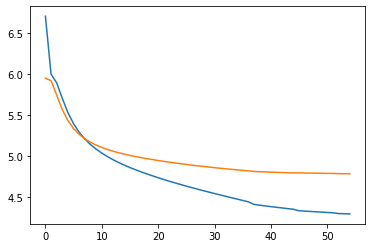

In [112]:
plt.plot(train_losses)
plt.plot(validation_losses)

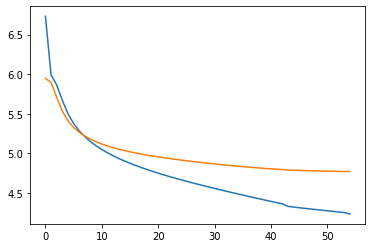

In [113]:
plt.plot(clip_train_losses)
plt.plot(clip_validation_losses)

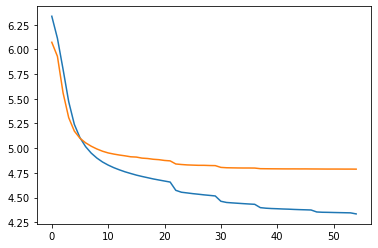

In [114]:
plt.plot(gated_train_losses)
plt.plot(gated_validation_losses)

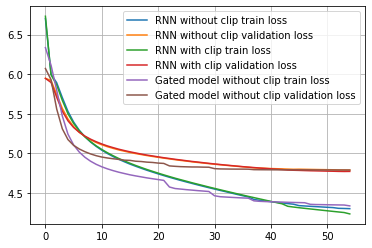

In [115]:
plt.grid()
plt.plot(train_losses, label = "RNN without clip train loss")
plt.plot(validation_losses, label = "RNN without clip validation loss")
plt.plot(clip_train_losses, label = "RNN with clip train loss")
plt.plot(clip_validation_losses, label = "RNN with clip validation loss")
plt.plot(gated_train_losses, label = "Gated model without clip train loss")
plt.plot(gated_validation_losses, label = "Gated model without clip validation loss")
plt.legend(loc="upper right")
plt.show()


### Perplexity

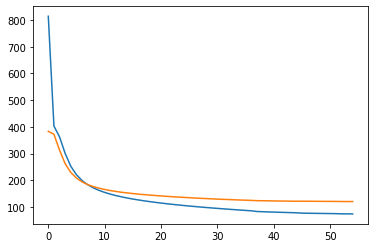

In [116]:
plt.plot(perplexity_train, label = "RNN without clip train perplexity")
plt.plot(perplexity_test, label = "RNN without clip validation perplexity")

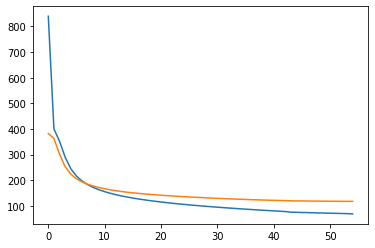

In [117]:
plt.plot(clip_perplexity_train, label = "RNN with clip train perplexity")
plt.plot(clip_perplexity_test, label = "RNN with clip validation perplexity")

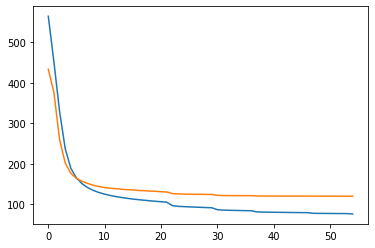

In [118]:
plt.plot(gated_perplexity_train, label = "Gated model without clip train perplexity")
plt.plot(gated_perplexity_test, label = "Gated model without clip validation perplexity")

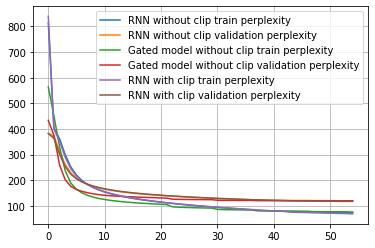

In [119]:
plt.grid()
plt.plot(perplexity_train, label = "RNN without clip train perplexity")
plt.plot(perplexity_test, label = "RNN without clip validation perplexity")
plt.plot(gated_perplexity_train, label = "Gated model without clip train perplexity")
plt.plot(gated_perplexity_test, label = "Gated model without clip validation perplexity")
plt.plot(clip_perplexity_train, label = "RNN with clip train perplexity")
plt.plot(clip_perplexity_test, label = "RNN with clip validation perplexity")
plt.legend(loc="upper right")
plt.show()

## Evaluation

Evaluate your final models.

### RNNModel without gradient clipping

In [120]:
evaluate(model, criterion, evalloader)

	Evaluation loss  4.79 | ppl   119.93


(4.786945530346462, 119.93447240535264)

### RNNModel with gradient clipping

In [121]:
evaluate(modelclip, criterion, evalloader)

	Evaluation loss  4.77 | ppl   117.90


(4.769863401140485, 117.90313542679611)

### GatedModel without gradient clipping

In [122]:
evaluate(gatedmodel, criterion, evalloader)

	Evaluation loss  4.79 | ppl   119.97


(4.787237201418195, 119.96945892348644)

## Text Generation

Generate text with your final models.

### RNNModel without gradient clipping

In [123]:
generate(model, list(eval_dataset.data[300:500]), train_dataset.data_idx, train_dataset.idx_data, len_hist=100, len_gen=100)

'for she really did know where her friend was to be found . wickham indeed had gone to her on their first arrival in london , and had she been able to receive them into her house , they would have taken up their abode with her . at length , however , our kind friend procured the wished for direction . they were in street . he saw wickham , and afterwards insisted on seeing lydia . his first object with her , he acknowledged , had been to persuade her to quit her present disgraceful situation , and return to her friends as soon as they could be prevailed on to receive her , offering his assistance , as far as it would go . but he found lydia absolutely resolved on remaining where she was . she cared for none of her friends she wanted no help of his she would not hear of leaving wickham . she was sure they should be married some time or other , and it did not much signify when . since such were her feelings , it only remained , he thought , to secure and expedite a marriage , =====> or g

### RNNModel with gradient clipping

In [124]:
generate(modelclip, list(eval_dataset.data[300:500]), train_dataset.data_idx, train_dataset.idx_data, len_hist=100, len_gen=100)

'for she really did know where her friend was to be found . wickham indeed had gone to her on their first arrival in london , and had she been able to receive them into her house , they would have taken up their abode with her . at length , however , our kind friend procured the wished for direction . they were in street . he saw wickham , and afterwards insisted on seeing lydia . his first object with her , he acknowledged , had been to persuade her to quit her present disgraceful situation , and return to her friends as soon as they could be prevailed on to receive her , offering his assistance , as far as it would go . but he found lydia absolutely resolved on remaining where she was . she cared for none of her friends she wanted no help of his she would not hear of leaving wickham . she was sure they should be married some time or other , and it did not much signify when . since such were her feelings , it only remained , he thought , to secure and expedite a marriage , =====> and 

### GatedModel without gradient clipping

In [125]:
generate(gatedmodel, list(eval_dataset.data[300:500]), train_dataset.data_idx, train_dataset.idx_data, len_hist=100, len_gen=100)

'for she really did know where her friend was to be found . wickham indeed had gone to her on their first arrival in london , and had she been able to receive them into her house , they would have taken up their abode with her . at length , however , our kind friend procured the wished for direction . they were in street . he saw wickham , and afterwards insisted on seeing lydia . his first object with her , he acknowledged , had been to persuade her to quit her present disgraceful situation , and return to her friends as soon as they could be prevailed on to receive her , offering his assistance , as far as it would go . but he found lydia absolutely resolved on remaining where she was . she cared for none of her friends she wanted no help of his she would not hear of leaving wickham . she was sure they should be married some time or other , and it did not much signify when . since such were her feelings , it only remained , he thought , to secure and expedite a marriage , =====> she 

## Extra Questions:
Use your own words.

### Q1) Explain teacher forcing and give its advantages and disadvantages. (5 points)

Teacher forcing is a strategy that is used generally in sequence to sequence models. It takes the actual output of the last step's output as an input instead of using the output predicted by the model.

Advantages: 
  * Since the actual target is used, the error that the model did will decrease, especially at the beginning of the training, the model may make wrong predictions. If it continues to use wrong predictions as input in the next steps, then 1 wrong prediction may affect the predictions in the next steps.

Disadvantages:
  * It is only used in the training part because the target is known. But when evaluating the model, we do not have the information about the actual output, it should evaluate the model with predicted output. So, the Model may not perform well in testing steps.

### Q2) Explain encoder-decoder sequence-to-sequence architectures. Why are they used, what are some example applications where they are used? (5 points)

Encoder decoder seq2seq architectures are used when inputs and outputs are not mapped to an exact length. For example, in machine translation, "entarte" verb in french refers to "hit with a pie" in English and these words do not have 1-1 mapping.

Encoder Part consists of LSTM or GRU recurrent unit cells, each of them gets input and they are forwarded through the next steps. In the end, it will reach the encoded state.

The decoder part consists of recurrent units that produce output from encoded vectors and outputs from the previous step. The number of decoder units is expected from the model and it starts with [START] token and it ends when the model produced the [END] token.

It can be used in Machine Translation, Speech Recognition, Video Captioning, Dialog, Code generation, Parsing, Summarization and it can be applied to any sequential problem with different number of inputs and outputs

### Q3) Why is attention used in encoder-decoder sequence-to-sequence architectures? (5 points)

Encoding all of the source sequences into a single vector and passing it to the decoder causes a bottleneck in the model. The decoder part only takes an encoded vector as an input. But the attention mechanism cares about the output from the encoder steps. It helps the decoder learns to focus on the input sequence.

It used because: 
 * Allows decoder to reach out to output of the encoder
 * It solves bottleneck problems. Sees source directly
 * Helps vanishing gradient problem
 * We can see where the output is inspired.



#### Links to models:
RNN Without Clip: https://drive.google.com/file/d/157weM4L-2rG6YDQZ83kguusZhqEUrROk/view?usp=sharing

RNN With Clip: https://drive.google.com/file/d/1lVuzuRtxjgD4iznmJv-sXMT-BeAkzp2R/view?usp=sharing

Gated Model Without Clip: https://drive.google.com/file/d/1lVuzuRtxjgD4iznmJv-sXMT-BeAkzp2R/view?usp=sharing